# 0.0 Imports

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import pickle
import warnings

from IPython.core.display     import HTML
from IPython.display          import Image

from matplotlib import pyplot as plt

from datetime            import datetime
from matplotlib.gridspec import GridSpec
from functools import reduce

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import KMeans

warnings.filterwarnings ("ignore")

# 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False).index
    
    null_data = pd.concat([df.isnull().sum(axis=0), 
                           (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False), 
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes], 
                          axis=1)
    
    null_data = null_data.rename(columns={0: '#', 
                                          1: '% null', 
                                          2: 'type'}).sort_values(ascending=False, 
                                                                  by='% null')
    
    return null_data

def plot_num(df, feature):
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=feature, data=df, color='firebrick', ax=fig.add_subplot(gs[0,0]))
    plt.ylabel(feature)
    sns.stripplot(y=df[feature], color='darkcyan', ax=fig.add_subplot(gs[0,1]))
    plt.ylabel(None)
    plt.show()

def plot_cat(df, feature):
    fig = plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches:
        
        ax.annotate(f'\n{p.get_height()}', 
                    (p.get_x()+0.4, p.get_height()+5), 
                    ha='center', 
                    color='black')
        
    plt.xlabel('\n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()

def scaler(df):
    df2 = df.copy()
    for column in df2:
        minimo = df2[column].min()
        maximo = df2[column].max()
        df2[column] = (df[column] - minimo)/(maximo - minimo)
    return df2

# 0.2 Data Collection

In [4]:
df = pd.read_csv( 'marketing_campaign.csv', delimiter = '\t')
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# 1.0 Data Description

In [5]:
df1 = df.copy()

In [6]:
df1.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

### 1.1 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 2240
Number of Cols: 29


### 1.2 Data Types

In [8]:
df1.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

- Change Types

In [9]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, dayfirst=True)

In [10]:
df  = pd.get_dummies(df)

In [11]:
df.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Z_Revenue,Response,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,...,11,1,0,0,1,0,0,0,0,0,0,1,0,0,0
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,...,11,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,...,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,...,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,...,11,0,0,0,0,0,1,0,0,0,1,0,0,0,0


### 1.3 Check NA

In [12]:
show_null(df)

,#,% null,type
Income,24,0.010714,float64
ID,0,0.000000,int64
Education_Master,0,0.000000,uint8
Complain,0,0.000000,int64
Z_CostContact,0,0.000000,int64
...,...,...,...
NumCatalogPurchases,0,0.000000,int64
NumStorePurchases,0,0.000000,int64
NumWebVisitsMonth,0,0.000000,int64
AcceptedCmp3,0,0.000000,int64


#### 1.3.1 Replaced NA

In [13]:
df.dropna(inplace=True)

### 1.4 Columns Description

#### People
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

#### Products
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

#### Promotion
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### 1.5 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.5.1 Numerical Atributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,0.0,11191.0,11191.0,5592.159821,5458.5,3245.937415,0.039832,-1.190028
1,Year_Birth,1893.0,1996.0,103.0,1968.805804,1970.0,11.981394,-0.349944,0.717464
2,Income,1730.0,666666.0,664936.0,52247.251354,NaN,25167.396174,6.763487,159.636700
3,Kidhome,0.0,2.0,2.0,0.444196,0.0,0.538278,0.635288,-0.779661
4,Teenhome,0.0,2.0,2.0,0.506250,0.0,0.544417,0.407115,-0.986235
5,Recency,0.0,99.0,99.0,49.109375,49.0,28.955987,-0.001987,-1.201897
6,MntWines,0.0,1493.0,1493.0,303.935714,173.5,336.522251,1.175771,0.598744
7,MntFruits,0.0,199.0,199.0,26.302232,8.0,39.764555,2.102063,4.050976
8,MntMeatProducts,0.0,1725.0,1725.0,166.950000,67.0,225.664984,2.083233,5.516724
9,MntFishProducts,0.0,259.0,259.0,37.525446,12.0,54.616784,1.919769,3.096461


#### 1.5.2 Categorical Atributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

Education           5
Marital_Status      8
Dt_Customer       663
dtype: int64

# 2.0. Exploratory Data Analysis (EDA)

In [17]:
df2 = df1.copy()

# Here the data matrix will be divided into three groups: people, products and promotion

#### 2.1.1 People

In [18]:
people = df2[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 
             'Recency', 'Complain']]

people.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Complain
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,0


#### 2.2.1.1 Income

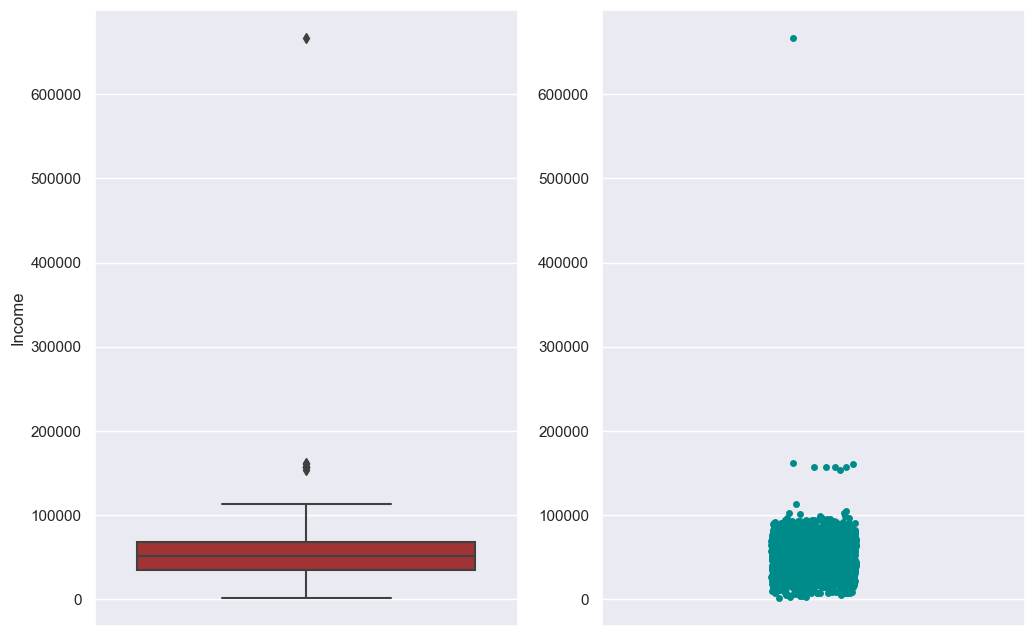

In [19]:
plot_num(people, 'Income')

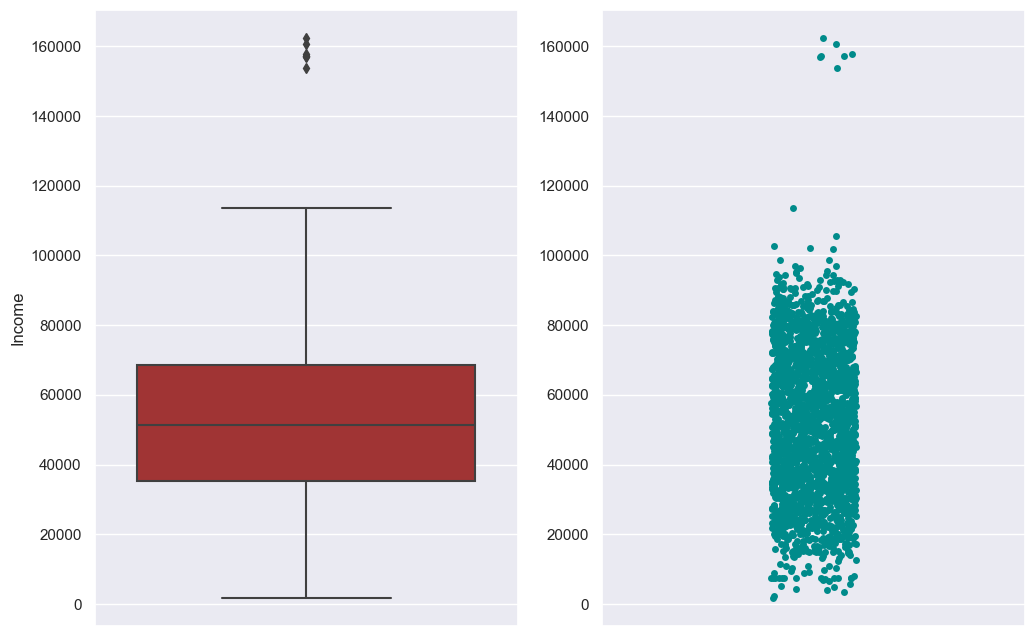

In [20]:
people = people[people.Income < 200000]
plot_num(people, 'Income')

In [21]:
people = people[people.Income < 200000]

#### 2.2.1.3 Year_Birth

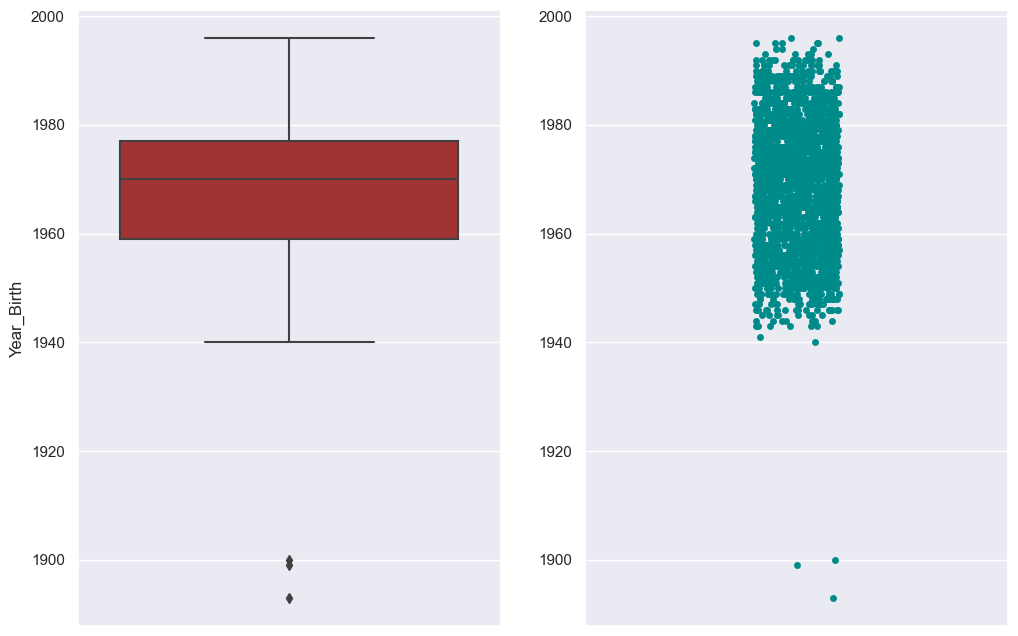

In [22]:
plot_num(people, 'Year_Birth')

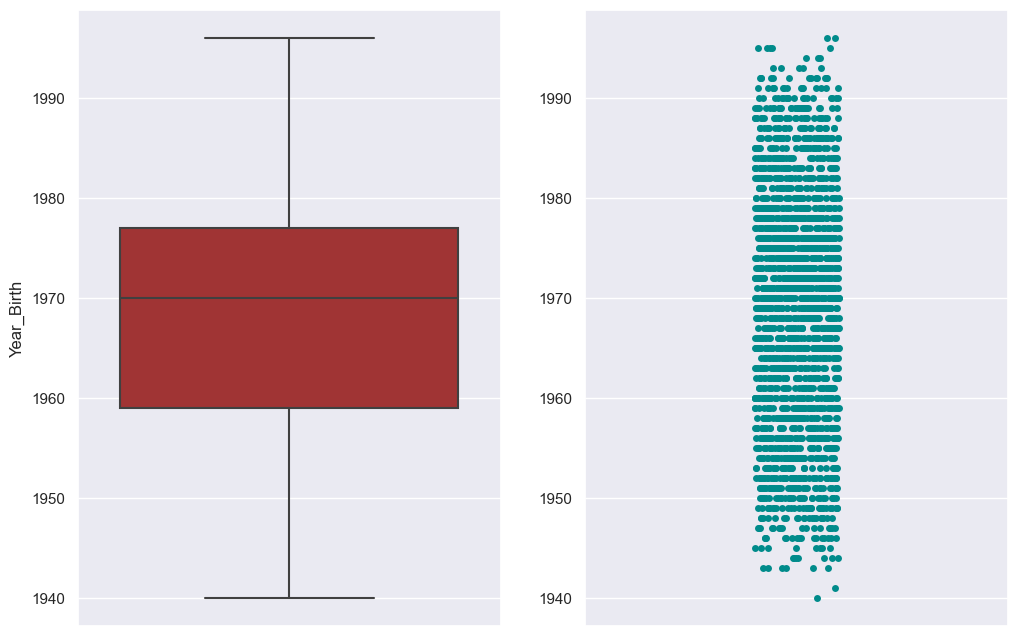

In [23]:
people = people[people.Year_Birth > 1930]
plot_num(people, 'Year_Birth')

#### 2.2.1.4 Education

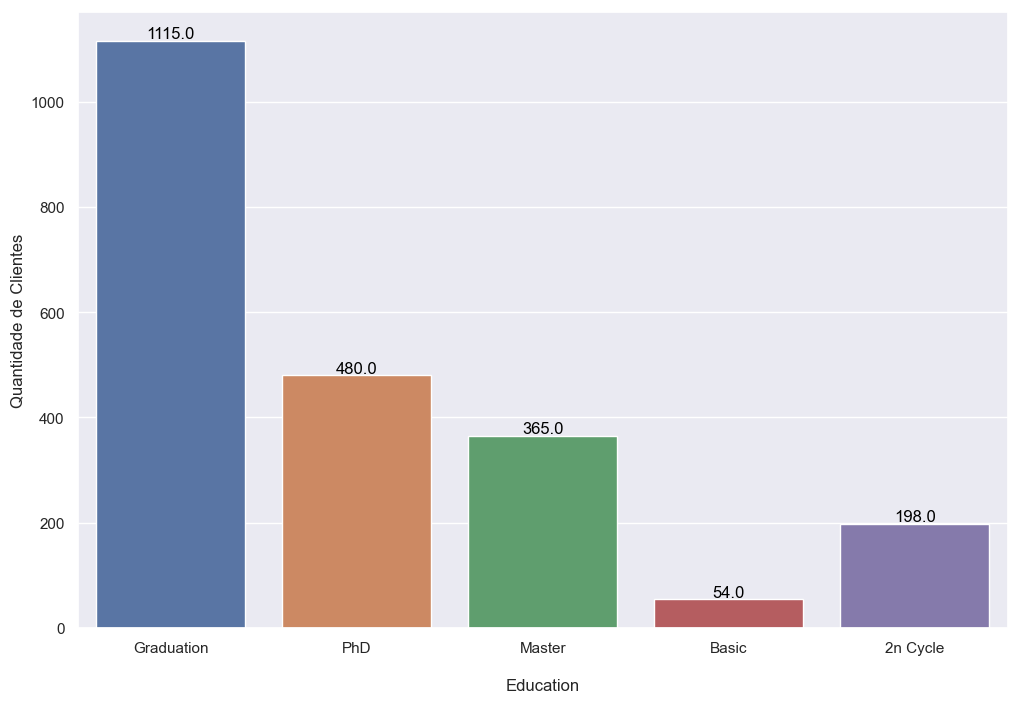

In [24]:
plot_cat(people, 'Education')
# Education is a categorical and ordinal variable, so it needs to be transformed into a number (feature engineering)

In [25]:
people.Education = people.Education.apply(lambda x: 0 if x=='Basic' 
                       else(1 if x=='2n Cycle' 
                            else(2 if x=='Graduation' 
                                 else(3 if x =='Master' 
                                      else(4 if x=='PhD' else None)))))

#### 2.2.2.5 Marital_Status

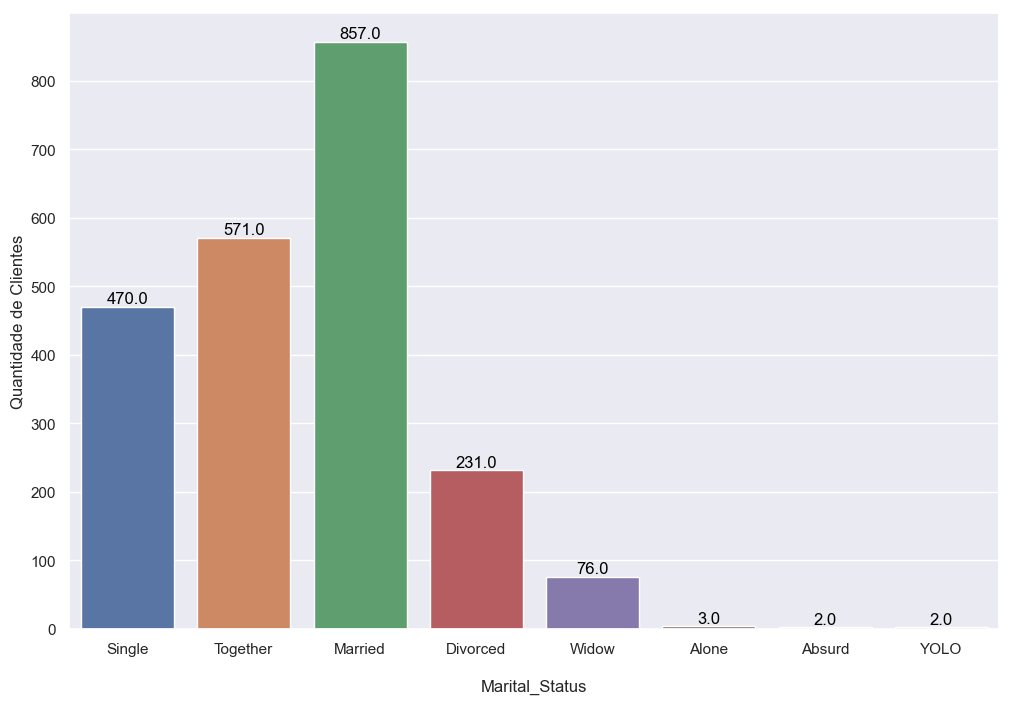

In [26]:
plot_cat(people, 'Marital_Status')

#handle such variable and remove some categories to single (feature engineering)

In [27]:
people = people[people.Marital_Status != 'Absurd']

In [28]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Single' if x=='Alone' 
                                                    else('Single' if x =='YOLO' else x))

In [29]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Together' if x=='Married' else x)

In [30]:
people.Dt_Customer = pd.to_datetime(people.Dt_Customer, dayfirst=True)

In [31]:
people = pd.get_dummies(people)

##### 2.2.1.6 Kidhome

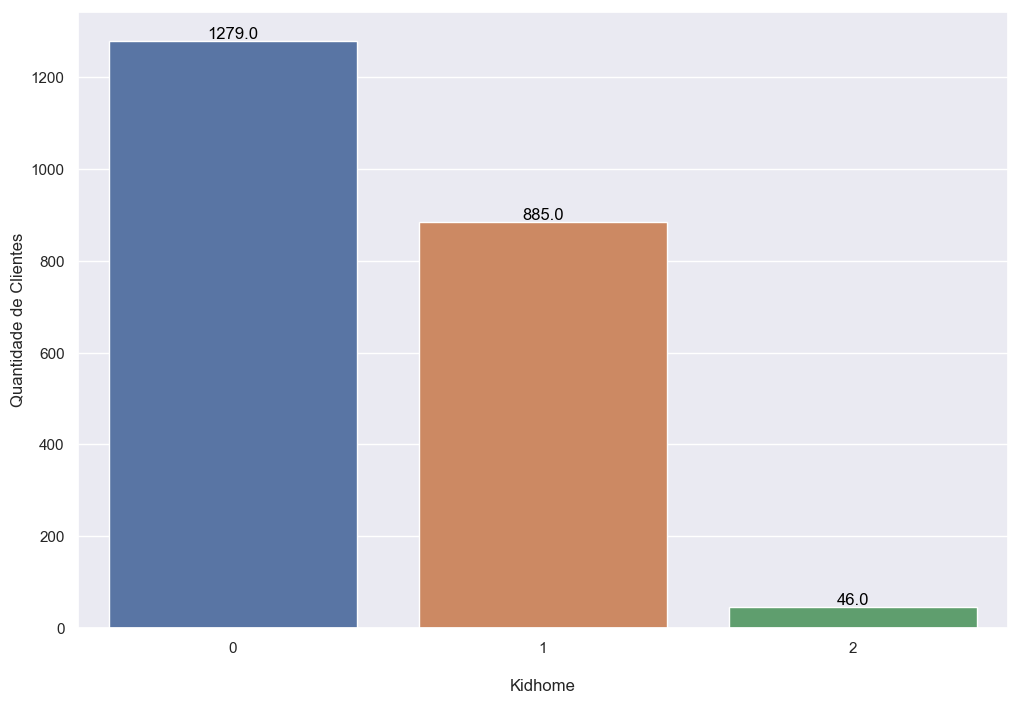

In [32]:
plot_cat(people, 'Kidhome')

##### 2.2.1.6 TeenHome

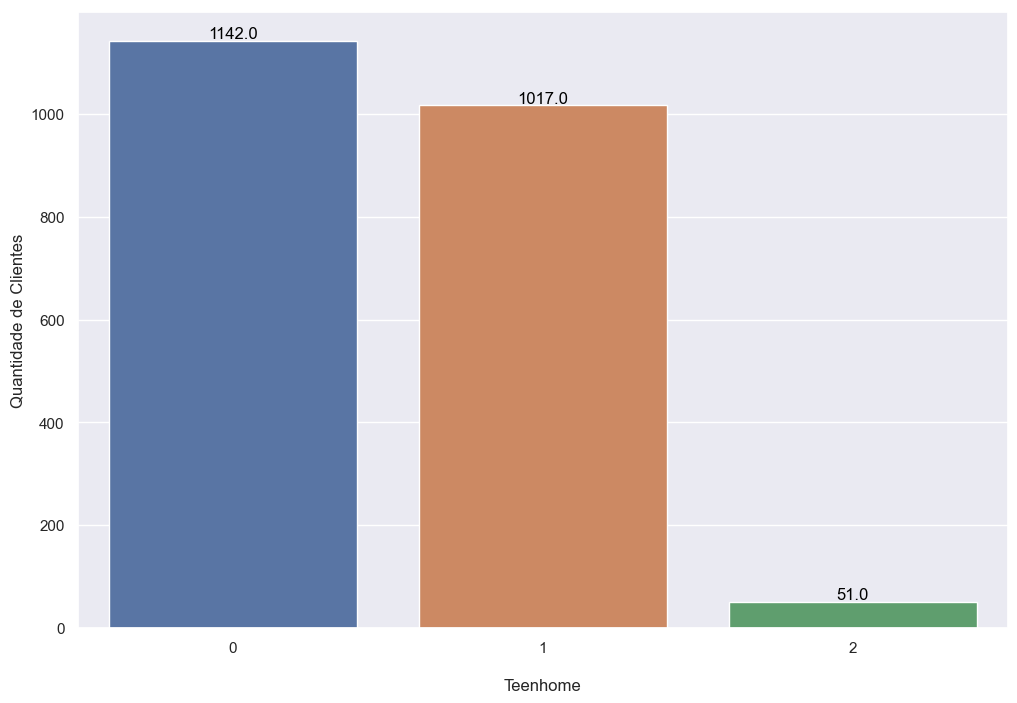

In [33]:
plot_cat(people, 'Teenhome')

# join the variable number of children and adolescents in just one variable.

In [34]:
people['ChildrenHome'] = people.Kidhome + people.Teenhome

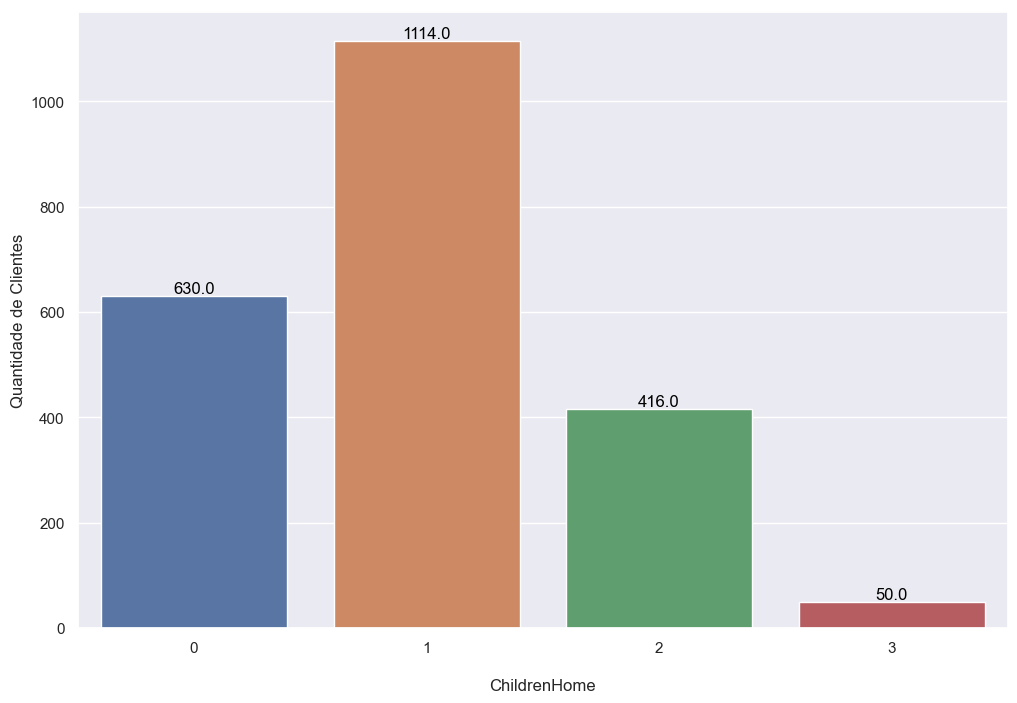

In [35]:
plot_cat(people, 'ChildrenHome')

##### 2.2.1.8 Dt_Customer

In [36]:
people.Dt_Customer.min()

Timestamp('2012-07-30 00:00:00')

In [37]:
people.Dt_Customer.max()

Timestamp('2014-06-29 00:00:00')

In [38]:
(people['Dt_Customer'] + pd.to_timedelta(people['Recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

In [39]:
people['LifeTime'] = (pd.to_datetime('2014-10-05') - people['Dt_Customer']).dt.days/30

#### 2.2.1.9 Recency

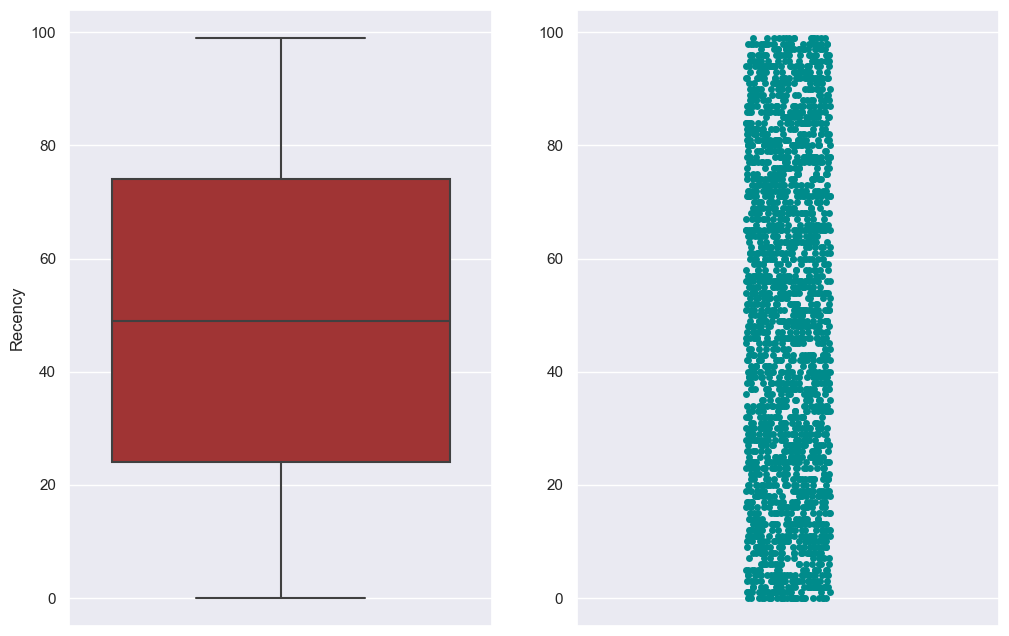

In [40]:
plot_num(people, 'Recency')

#### 2.2.1.10 Complain

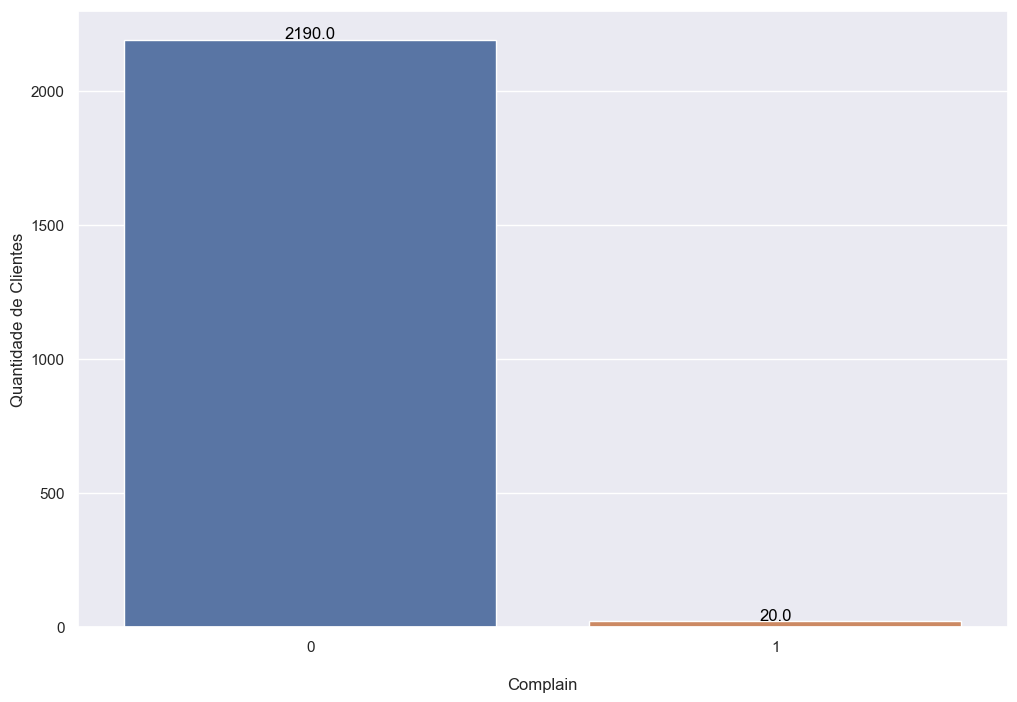

In [41]:
plot_cat(people, 'Complain')

In [42]:
people.drop(columns=['Complain'], inplace=True)

In [43]:
people.drop(columns=['Dt_Customer'], inplace=True)

#### 2.2.2 Products

In [44]:
products = df2[['ID','MntWines','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]

In [45]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,5524,635,88,546,172,88,88
1,2174,11,1,6,2,1,6
2,4141,426,49,127,111,21,42
3,6182,11,4,20,10,3,5
4,5324,173,43,118,46,27,15


##### 2.2.2.1 MntWines

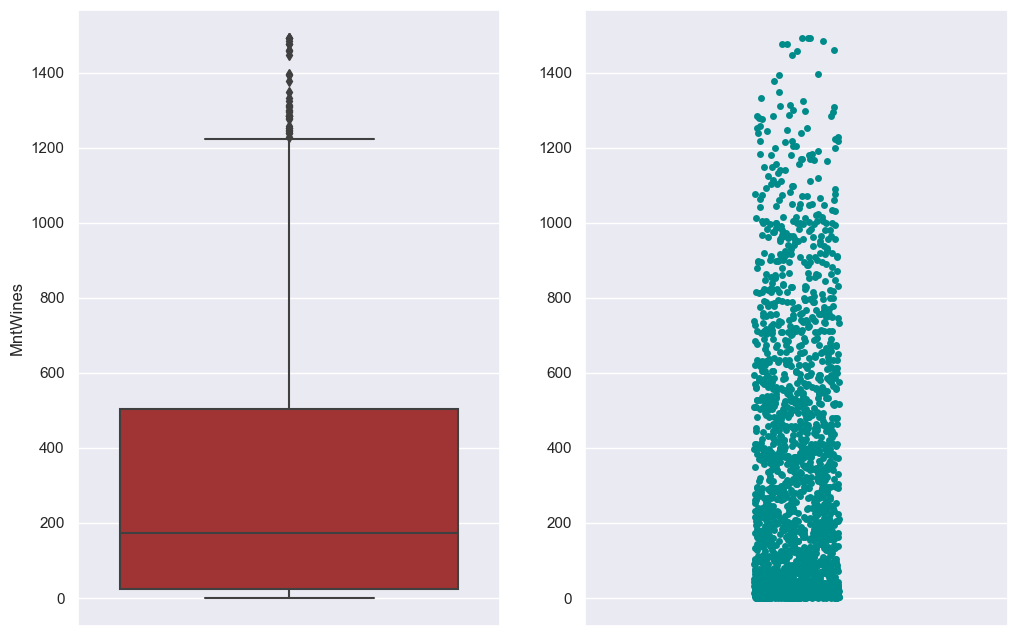

In [46]:
plot_num(products, 'MntWines')

##### 2.2.2.2 MntFruits

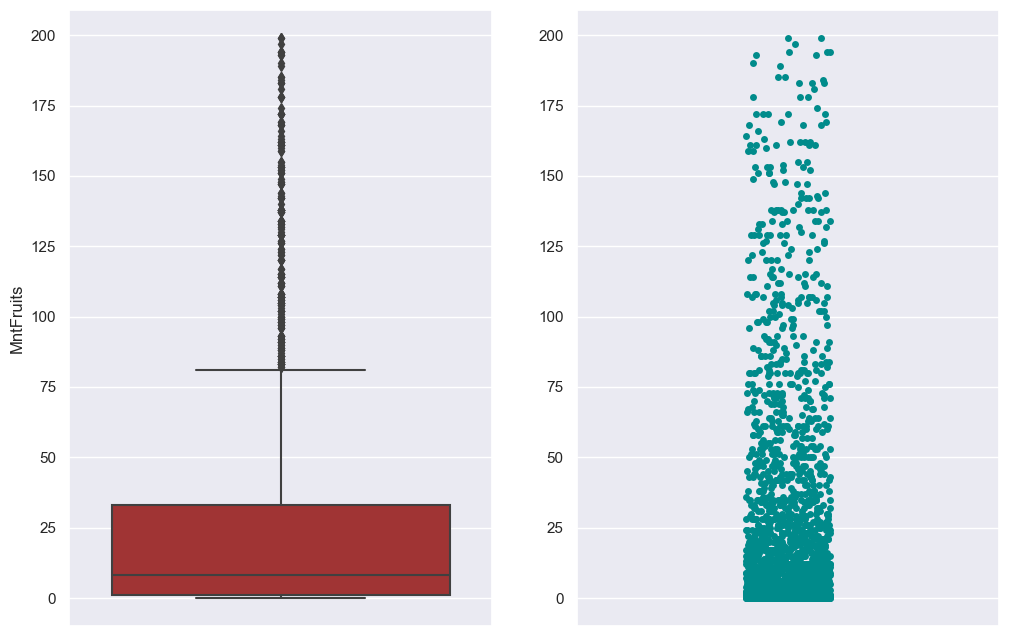

In [47]:
plot_num(products, 'MntFruits')

##### 2.2.2.3 MntMeatProducts

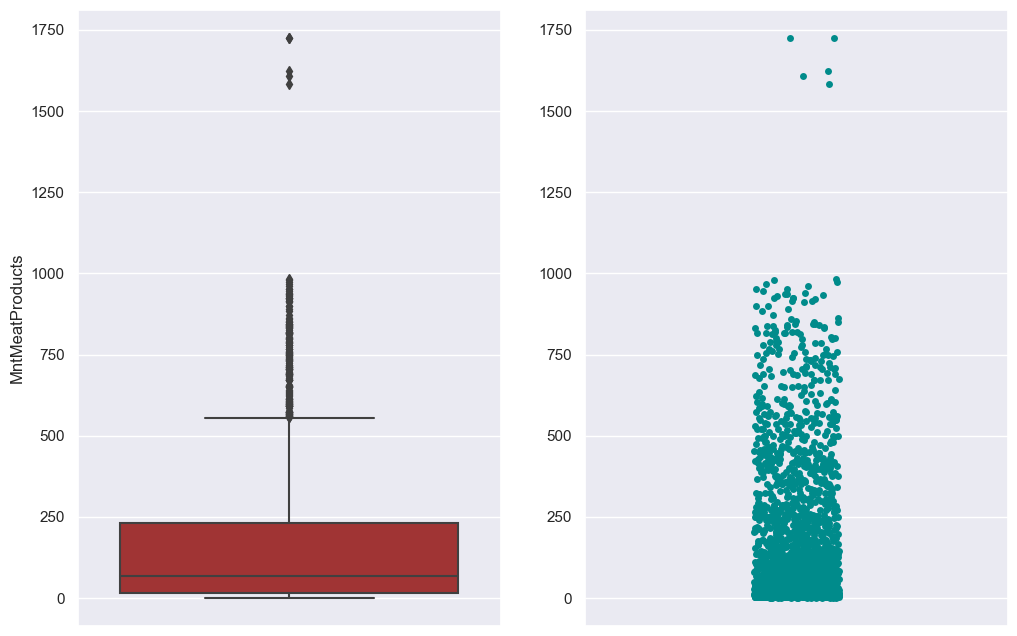

In [48]:
plot_num(products, 'MntMeatProducts')

##### 2.2.2.4 MntFishProducts

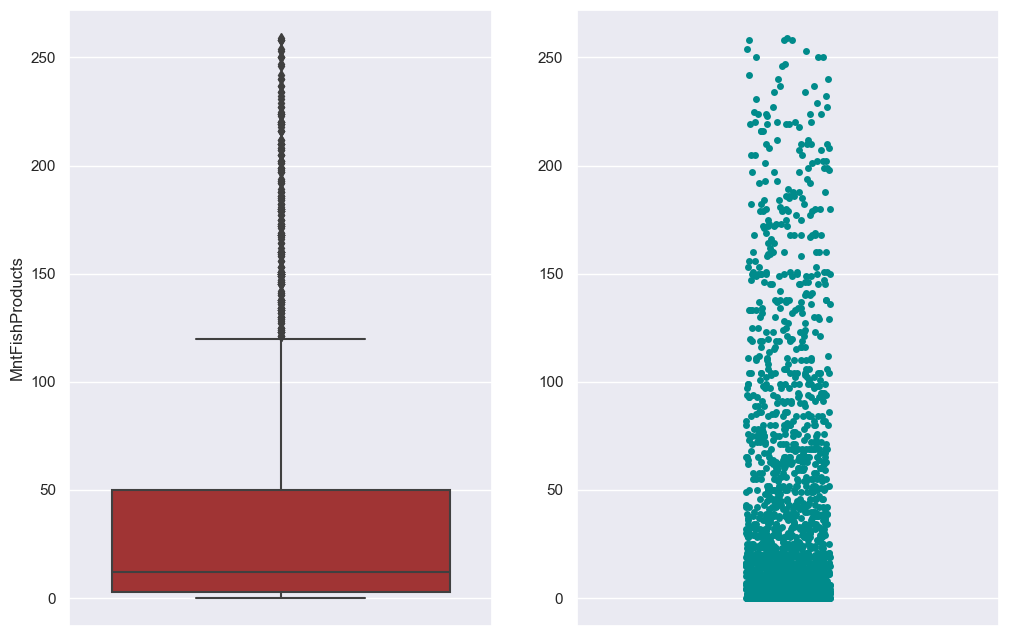

In [49]:
plot_num(products, 'MntFishProducts')

##### 2.2.2.5 MntSweetProducts

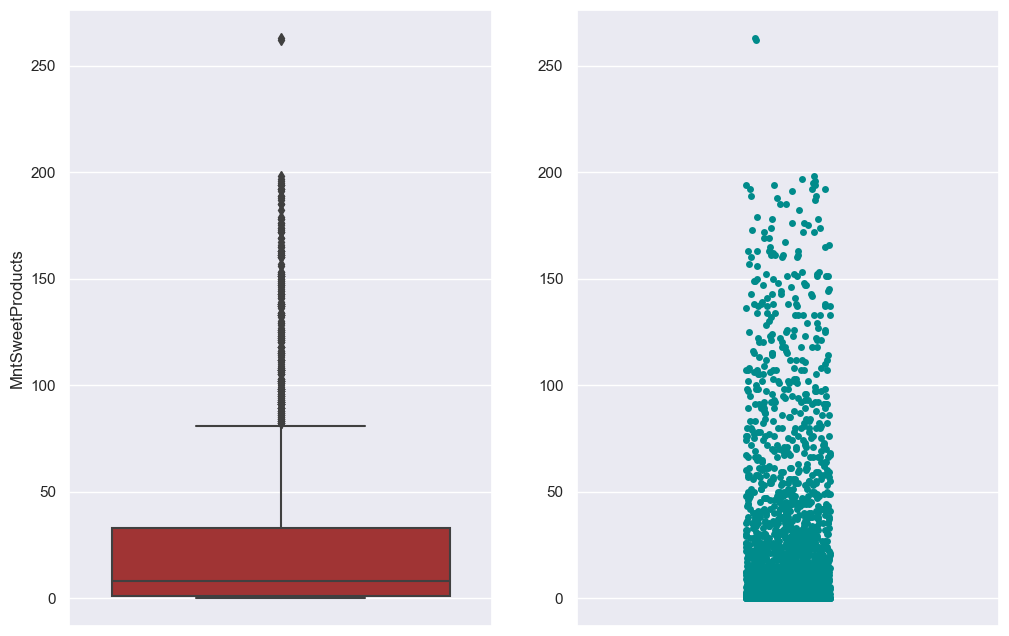

In [50]:
plot_num(products, 'MntSweetProducts')

##### 2.2.2.6 MntGoldProds

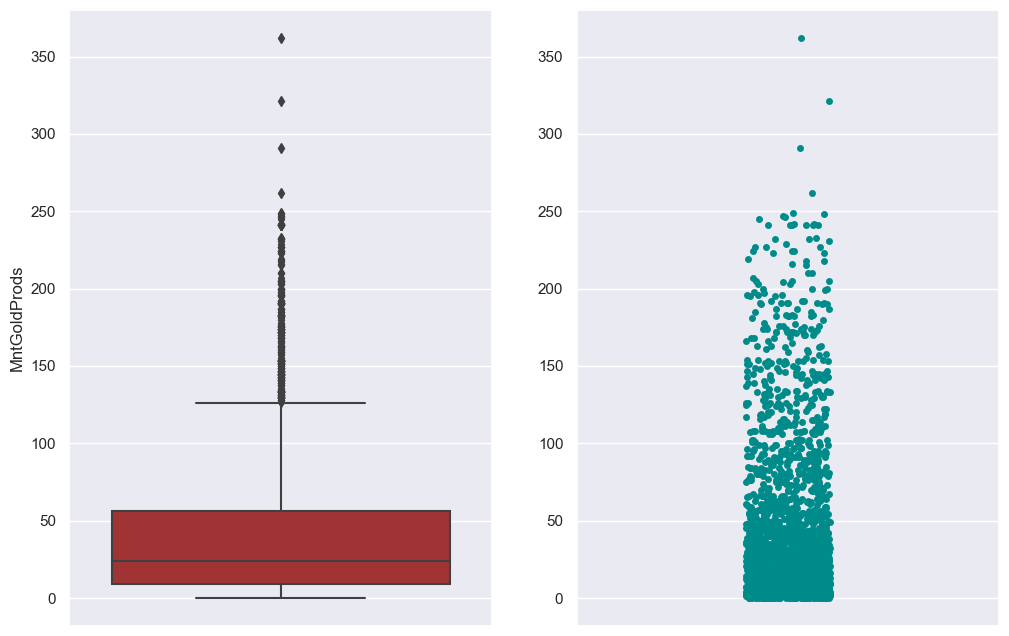

In [51]:
plot_num(products, 'MntGoldProds')

In [52]:
products['TotalAmountSpent'] = products.MntFishProducts + products.MntFruits + products.MntGoldProds \
+ products.MntMeatProducts + products.MntSweetProducts + products.MntWines

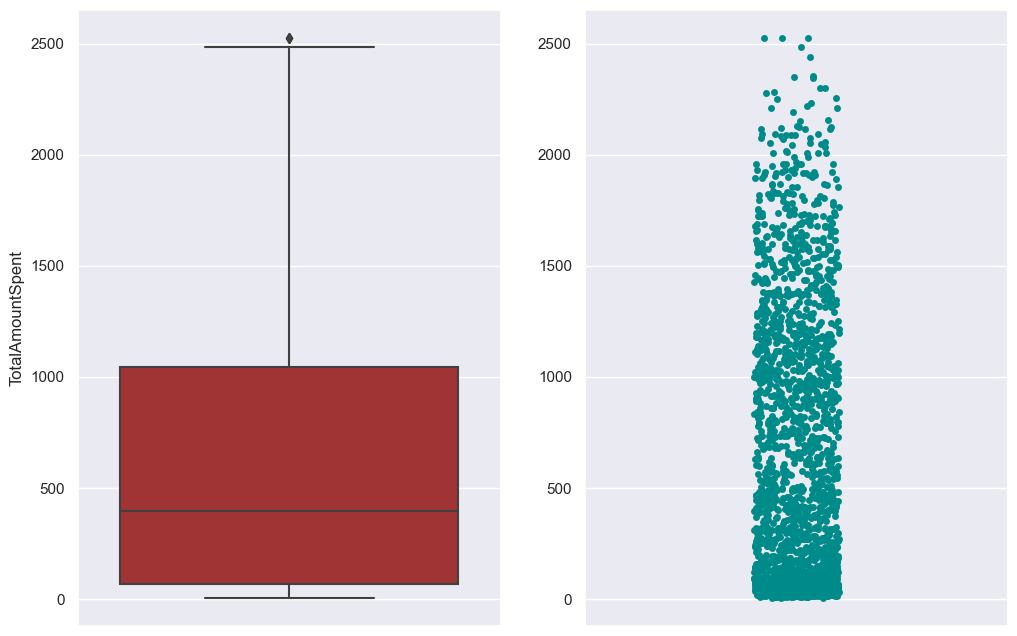

In [53]:
plot_num(products, 'TotalAmountSpent')

In [54]:
products.MntFishProducts = products.MntFishProducts/products['TotalAmountSpent']
products.MntFruits = products.MntFruits/products['TotalAmountSpent']
products.MntGoldProds = products.MntGoldProds/products['TotalAmountSpent']
products.MntMeatProducts = products.MntMeatProducts/products['TotalAmountSpent']
products.MntSweetProducts = products.MntSweetProducts/products['TotalAmountSpent']
products.MntWines = products.MntWines/products['TotalAmountSpent']

In [55]:
products.describe()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.458481,0.049505,0.249508,0.071532,0.050777,0.120196,605.798214
std,3246.662198,0.228411,0.055867,0.126633,0.077909,0.061184,0.108988,602.249288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,2828.250000,0.289506,0.008924,0.156250,0.012571,0.008621,0.038095,68.750000
50%,5458.500000,0.457482,0.029840,0.233447,0.048193,0.033333,0.086294,396.000000
75%,8427.750000,0.639143,0.070237,0.328227,0.104703,0.070411,0.169768,1045.500000
max,11191.000000,0.963303,0.445545,0.997110,0.590909,0.945848,0.894150,2525.000000


#### 2.2.3 Promotion

In [56]:
promotion = df2[['ID','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
                'AcceptedCmp5', 'Response']]

In [57]:
promotion.head()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
0,5524,0,0,0,0,0,1
1,2174,0,0,0,0,0,0
2,4141,0,0,0,0,0,0
3,6182,0,0,0,0,0,0
4,5324,0,0,0,0,0,0


In [58]:
promotion.describe()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.064286,0.013393,0.072768,0.074554,0.072768,0.149107
std,3246.662198,0.245316,0.114976,0.259813,0.262728,0.259813,0.356274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
promotion['AcceptedCmp'] = promotion.AcceptedCmp1 + promotion.AcceptedCmp2 + promotion.AcceptedCmp3 + promotion.AcceptedCmp4 + \
promotion.AcceptedCmp5 + promotion.Response

In [60]:
promotion['AcceptedCmp'].describe()

count    2240.000000
mean        0.446875
std         0.890543
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: AcceptedCmp, dtype: float64

In [61]:
promotion = promotion[['ID', 'AcceptedCmp']]

#### 2.2.4 Place

In [62]:
place = df2[['ID','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']]

In [63]:
place.head()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth
0,5524,8,10,4,3,7
1,2174,1,1,2,2,5
2,4141,8,2,10,1,4
3,6182,2,0,4,2,6
4,5324,5,3,6,5,5


In [64]:
place['TotalPurchases'] = place.NumWebPurchases + place.NumCatalogPurchases + place.NumStorePurchases

In [65]:
place[place.TotalPurchases == 0]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
655,5555,0,0,0,0,0,0
981,3955,0,0,0,0,14,0
1245,6862,0,0,0,15,20,0
1524,11110,0,0,0,0,14,0
1846,9931,0,0,0,15,19,0
2132,11181,0,0,0,0,0,0


In [66]:
place = place[place['TotalPurchases']>0]

In [67]:
place['NumWebPurchases'] = place['NumWebPurchases']/place['TotalPurchases']
place['NumCatalogPurchases'] = place['NumCatalogPurchases']/place['TotalPurchases']
place['NumStorePurchases'] = place['NumStorePurchases']/place['TotalPurchases']
place['NumDealsPurchases'] = place['NumDealsPurchases']/place['TotalPurchases']

In [68]:
place[place.NumDealsPurchases > 1]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
1042,10749,0.0,1.0,0.0,15.0,19,1


In [69]:
place = place[place['NumDealsPurchases']<=1]

##### 2.2.4.1 NumWebPurchases

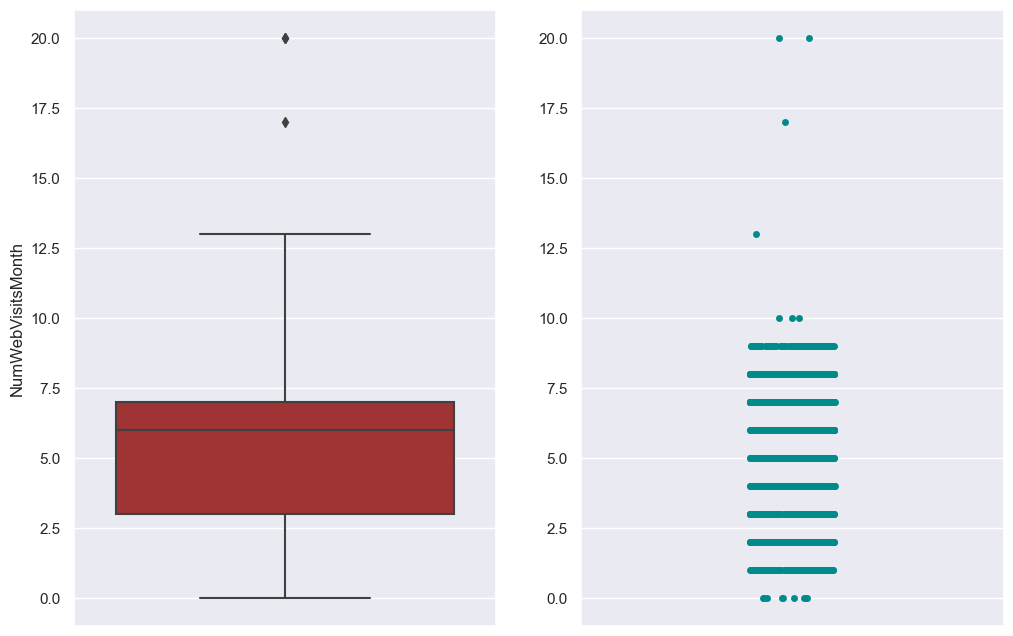

In [70]:
plot_num(place, 'NumWebVisitsMonth')

#### Joining the data

In [71]:
df_lista = [people, products, promotion, place]

In [72]:
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='ID'), df_lista)

In [73]:
df_final.shape

(2203, 27)

In [74]:
df_final.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

In [75]:
df_final.drop(columns=['ID'], inplace=True)

# 4.0 Data Preparetion

### MinMaxScaler

In [76]:
scaled_df = scaler(df_final)

# 5.0 Elbow method

In [77]:
inertia = []
num_clusters = range(1, 14)

for k in num_clusters:
    Model = KMeans(n_clusters=k)
    Model.fit(scaled_df)
    inertia.append(Model.inertia_)

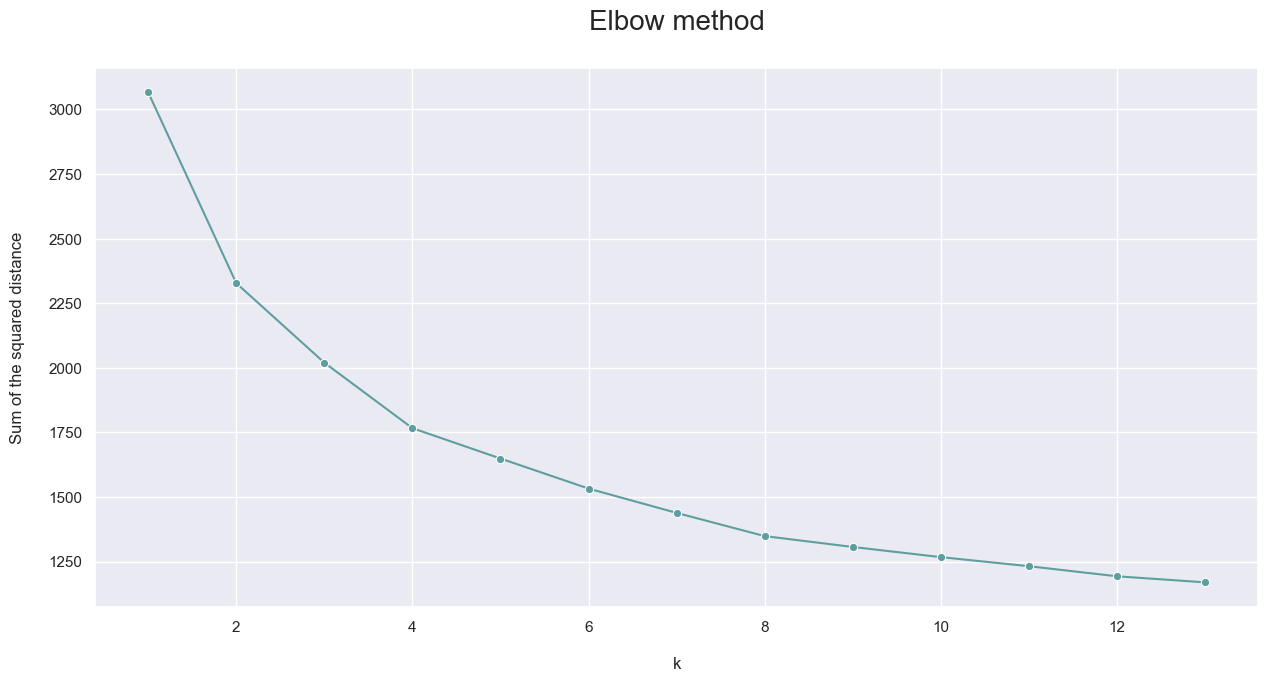

In [78]:
plt.figure(figsize=(15,7))
sns.lineplot(x=num_clusters, y=inertia, color='cadetblue', marker='o')
plt.xlabel('\nk', size=12)
plt.ylabel('Sum of the squared distance\n', size=12)
plt.title('Elbow method\n', size=20)
plt.show()

# 6.0 Allocation of weights

In [79]:
scaled_df.TotalAmountSpent = 8*scaled_df.TotalAmountSpent
scaled_df.TotalPurchases = 6*scaled_df.TotalPurchases
scaled_df.Recency = 4*scaled_df.Recency
scaled_df.NumWebVisitsMonth = 4*scaled_df.NumWebVisitsMonth
scaled_df.Income = 4*scaled_df.Income
scaled_df.LifeTime = 4*scaled_df.LifeTime
scaled_df.Year_Birth = 2*scaled_df.Year_Birth
scaled_df.ChildrenHome = 2*scaled_df.ChildrenHome
scaled_df.Education = 2*scaled_df.Education

In [80]:
scaled_df.describe()

,Year_Birth,Education,Income,Kidhome,Teenhome,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000,2203.000000
mean,1.032358,1.230141,1.238068,0.221289,0.253745,1.979431,0.103495,0.214707,0.647299,0.034498,0.633379,2.026362,0.477108,0.110423,0.249853,0.120857,0.053607,0.134151,1.908833,0.089877,0.330002,0.164580,0.505419,0.241032,1.060554,2.245530
std,0.417580,0.502410,0.530515,0.268605,0.272203,1.170504,0.304674,0.410712,0.477919,0.182547,0.499168,1.157569,0.237445,0.124819,0.126184,0.132076,0.064434,0.121894,1.915298,0.178555,0.120862,0.139301,0.148665,0.172198,0.470396,1.390384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.678571,1.000000,0.823182,0.000000,0.000000,0.969697,0.000000,0.000000,0.000000,0.000000,0.000000,1.035765,0.301382,0.020003,0.156637,0.021255,0.009126,0.042521,0.193882,0.000000,0.250000,0.000000,0.400000,0.083333,0.600000,0.967742
50%,1.071429,1.000000,1.223532,0.000000,0.000000,1.979798,0.000000,0.000000,1.000000,0.000000,0.666667,2.037196,0.477821,0.066438,0.234010,0.081269,0.034950,0.094632,1.239571,0.000000,0.333333,0.150000,0.500000,0.200000,1.200000,2.129032
75%,1.321429,1.500000,1.651204,0.500000,0.500000,2.989899,0.000000,0.000000,1.000000,0.000000,0.666667,3.027182,0.666694,0.155363,0.329124,0.175066,0.074329,0.189881,3.305522,0.200000,0.400000,0.250000,0.600000,0.333333,1.400000,3.483871
max,2.000000,2.000000,4.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,6.000000


# 7.0 Machine learning - KMeans

In [81]:
Model = KMeans(n_clusters=4)

In [82]:
clusters = Model.fit_predict(scaled_df)

In [83]:
clusters

array([1, 0, 3, ..., 3, 3, 0])

In [84]:
df_final['cluster'] = clusters

In [85]:
df_final

,Year_Birth,Education,Income,Kidhome,Teenhome,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent,AcceptedCmp,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases,cluster
0,1957,2,58138.0,0,0,58,0,1,0,0,0,25.366667,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,1617,1,0.363636,0.454545,0.181818,0.136364,7,22,1
1,1954,2,46344.0,1,1,38,0,1,0,0,2,7.033333,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,27,0,0.250000,0.250000,0.500000,0.500000,5,4,0
2,1965,2,71613.0,0,0,26,0,0,1,0,0,13.666667,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,776,0,0.400000,0.100000,0.500000,0.050000,4,20,3
3,1984,2,26646.0,1,0,26,0,0,1,0,1,7.900000,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,53,0,0.333333,0.000000,0.666667,0.333333,6,6,0
4,1981,4,58293.0,1,0,94,0,0,1,0,1,8.633333,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,422,0,0.357143,0.214286,0.428571,0.357143,5,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,1967,2,61223.0,0,1,46,0,0,1,0,1,15.966667,0.528710,0.032066,0.135720,0.031320,0.087994,0.184191,1341,0,0.562500,0.187500,0.250000,0.125000,5,16,1
2199,1946,4,64014.0,2,1,56,0,0,1,0,3,3.900000,0.914414,0.000000,0.067568,0.000000,0.000000,0.018018,444,1,0.533333,0.133333,0.333333,0.466667,7,15,3
2200,1981,2,56981.0,0,0,91,1,0,0,0,0,8.433333,0.731668,0.038678,0.174859,0.025786,0.009670,0.019339,1241,1,0.111111,0.166667,0.722222,0.055556,6,18,3
2201,1956,3,69245.0,0,1,8,0,0,1,0,1,8.466667,0.507711,0.035587,0.253855,0.094899,0.035587,0.072361,843,0,0.285714,0.238095,0.476190,0.095238,3,21,3


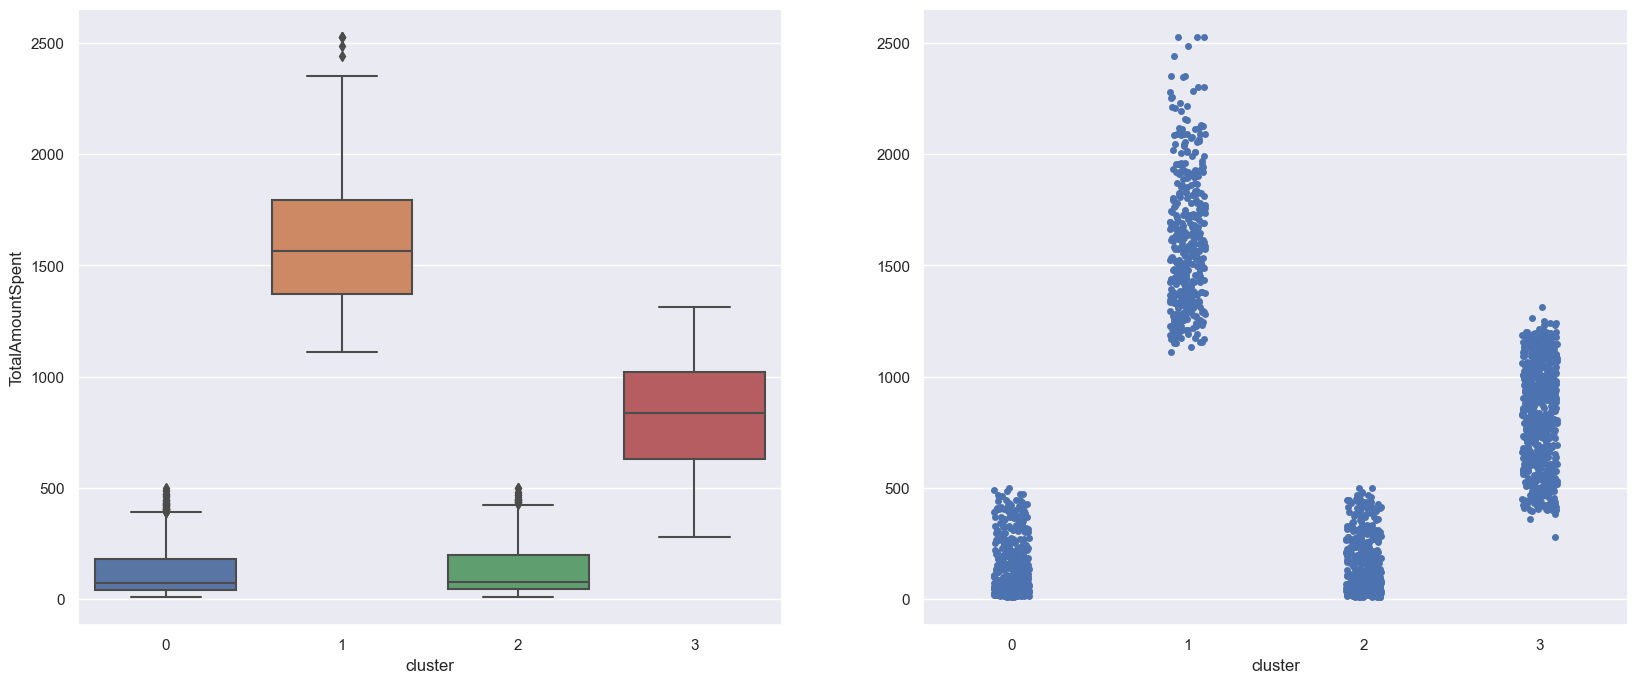

In [86]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalAmountSpent')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalAmountSpent', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

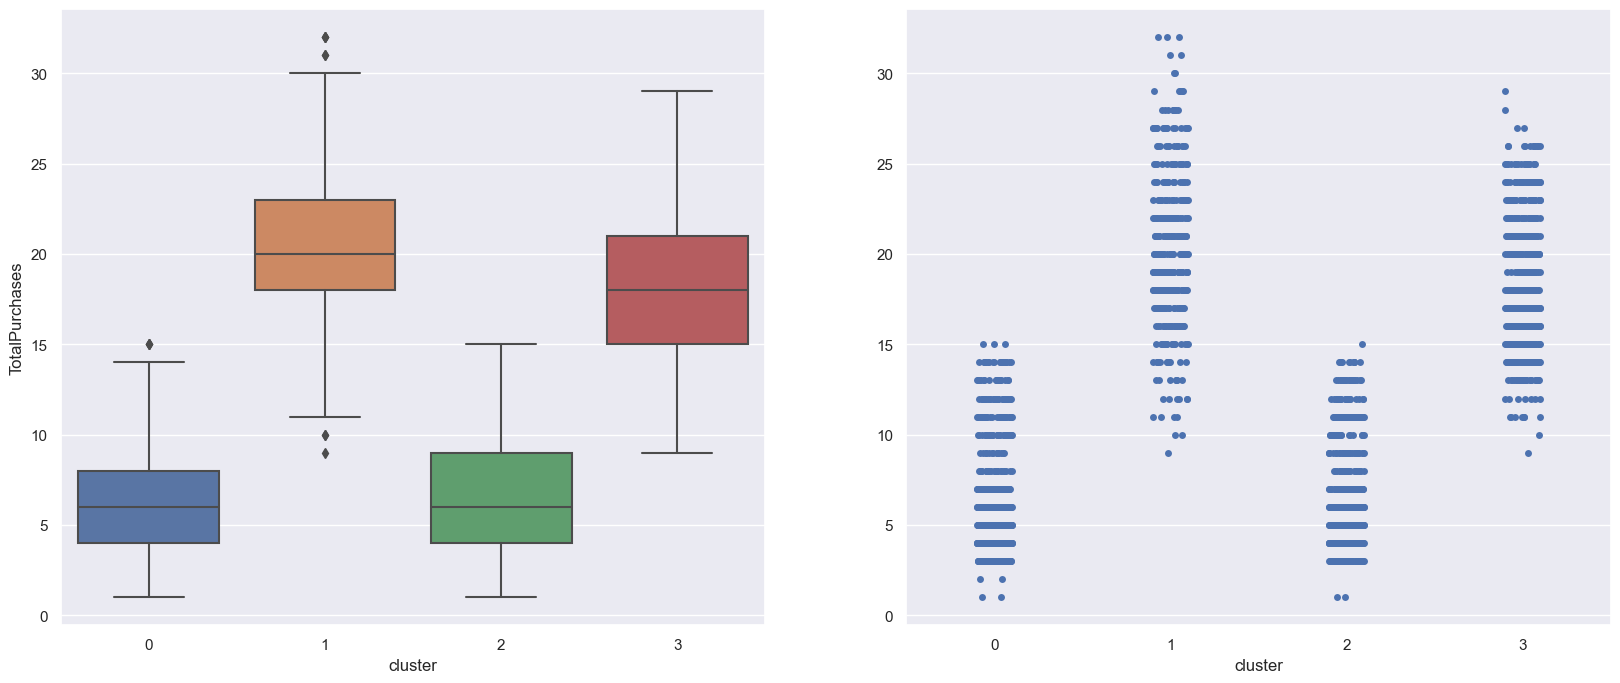

In [87]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('TotalPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='TotalPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

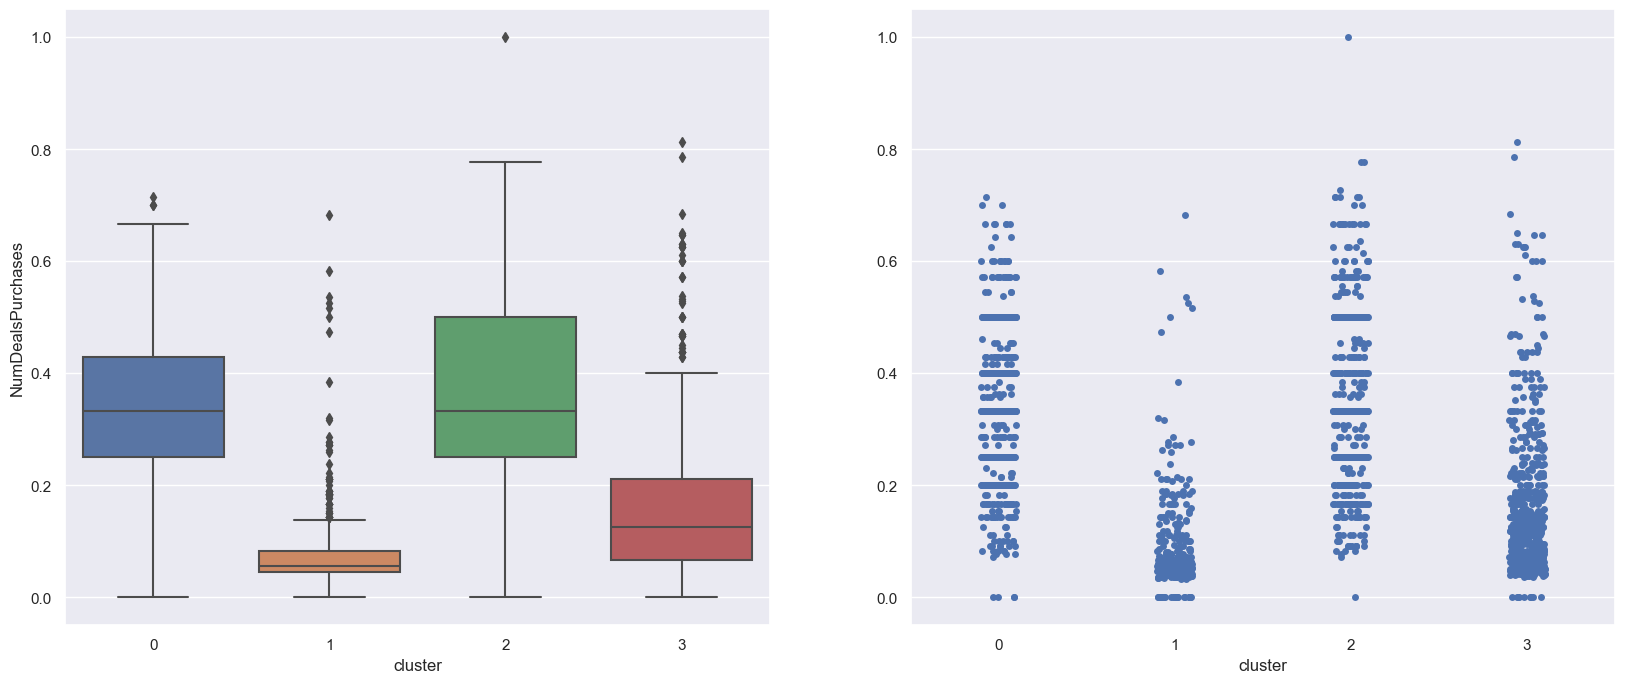

In [88]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumDealsPurchases')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumDealsPurchases', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

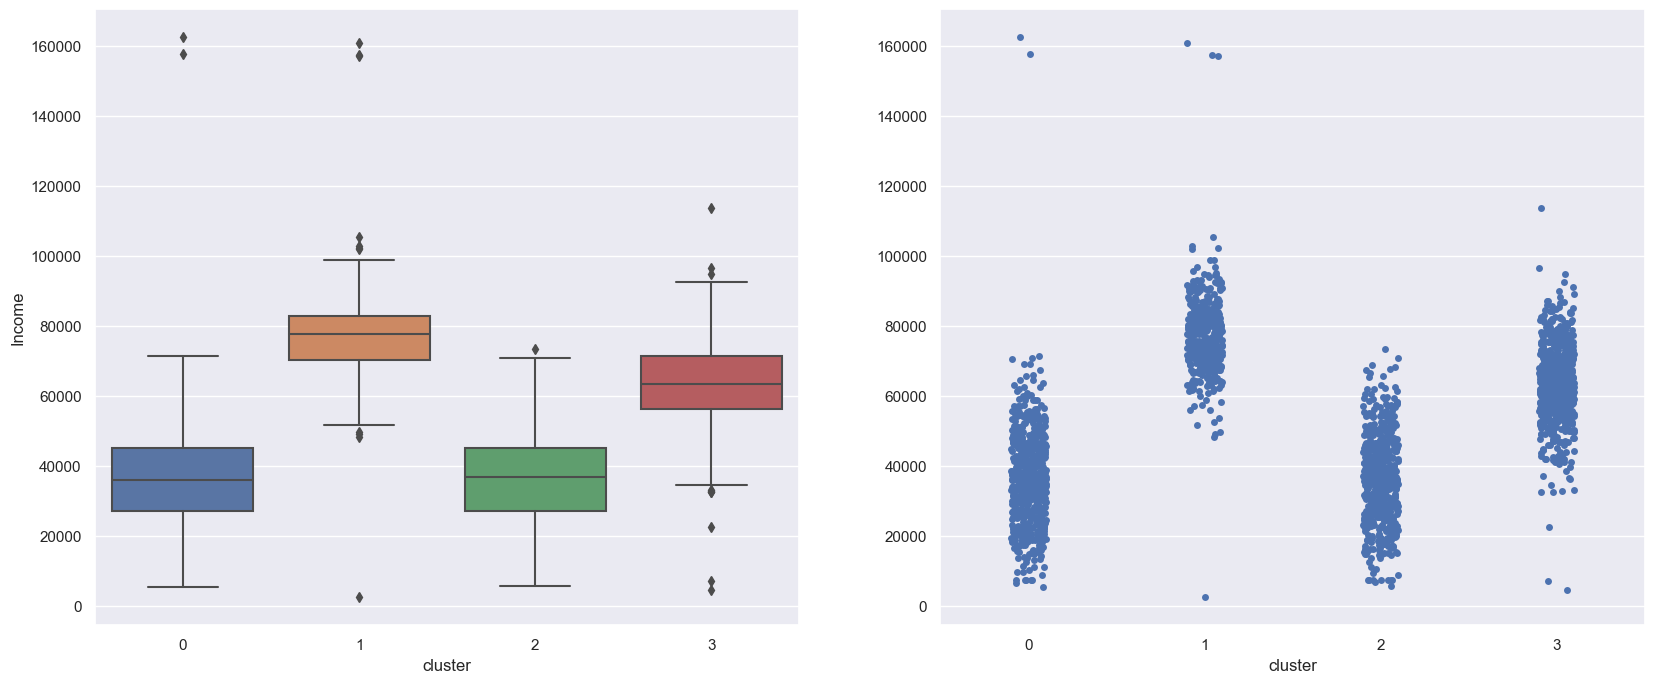

In [89]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Income')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Income', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

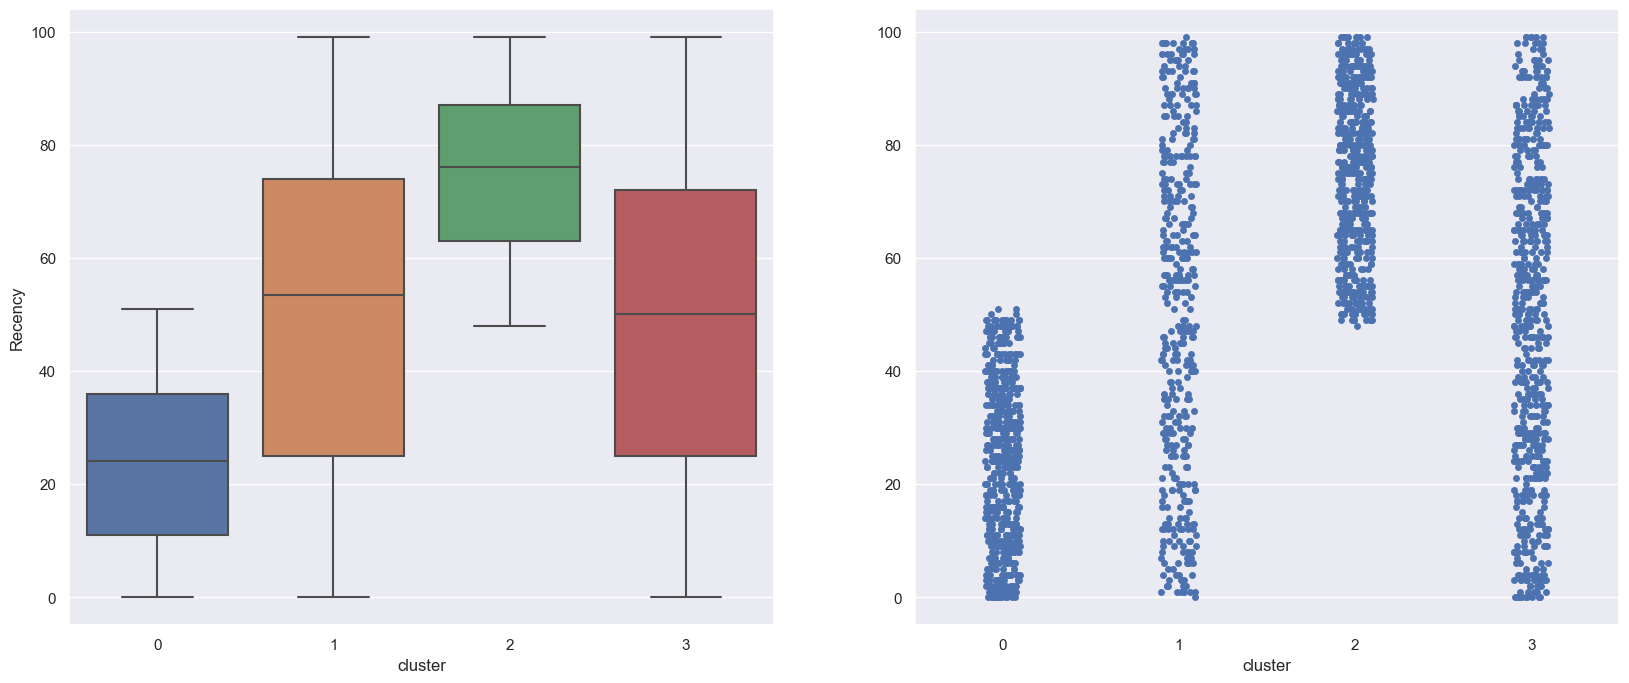

In [90]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('Recency')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='Recency', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

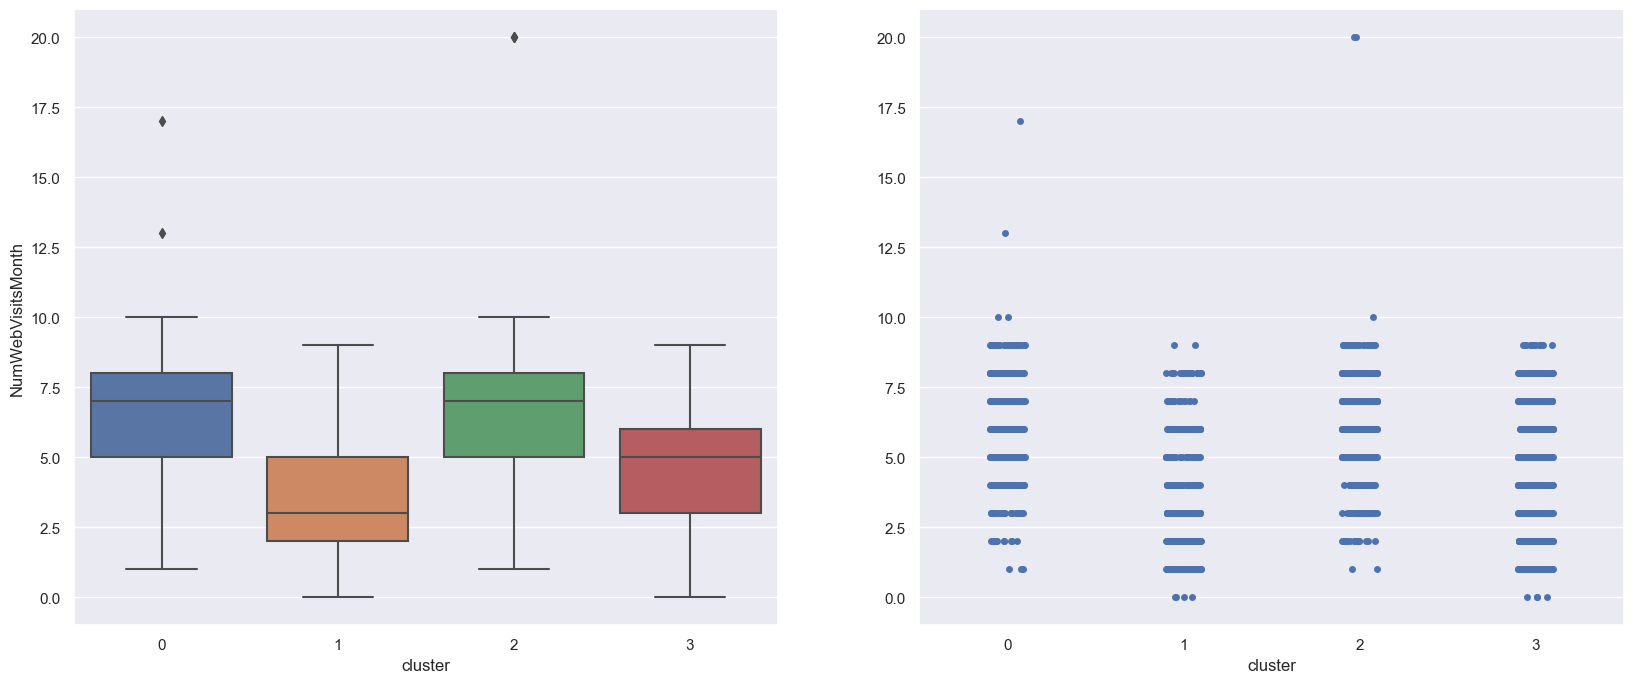

In [91]:
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,0]))
plt.ylabel('NumWebVisitsMonth')
plt.xlabel('cluster')
sns.stripplot(x='cluster', y='NumWebVisitsMonth', data=df_final, ax=fig.add_subplot(gs[0,1]))    
plt.ylabel(None)
plt.xlabel('cluster')
plt.show()

# 8.0 Results

#### Cluster 0:
- Group with the highest value and the fewest customers. They have high income and higher education levels, buy the most, and have the highest average receipt of all groups. They tend not to visit the company's website as often or buy through promotions, preferring to buy through catalogs and directly in the store. Their favorite categories are meat and wine. Most have no children at home and have been registered customers for a long time.

#### Cluster 1:
- This is a young group with lower purchasing power, the least active of all. The company has to be careful because they are churn and not buying as much as they used to. It is the group least likely to accept advertising campaigns. It is an important opportunity for the company to promote products aimed more at children. Group that makes the most purchases due to promotions (%). They like to shop in a shop. They are the ones who visit the website most often. They like golden pens more than the other higher value clusters.

#### Cluster 2:
- Younger customers who have less purchasing power but are the most active within the company. It is the group that has taken the least time. Customers like to shop in sales, in stores and on the website. They prefer more gold products than the other higher value clusters.

#### Cluster 3: 
- It is a group that makes a lot of purchases, but with an average ticket much lower than the previous group, but still bringing a lot of revenue to the company. Clients have a relatively high annual salary, are older and usually have a child at home. It is the group that appreciates the wine category the most and has the largest number of customers.

# 9.0 Saving the model

In [92]:
# save the model to disk
filename = 'finished_model.sav'
pickle.dump(Model, open(filename, 'wb'))

In [93]:
# load the model from disk
Model = pickle.load(open(filename, 'rb'))